# Feature Engineering Pipeline

This notebook computes engineered features from raw time series data and validates data quality.

**Input:** Raw time series from the `raw_series` database table

**Output:** Computed features stored in the `features` table with forward-filling and business day alignment

**Feature types computed:**
- Basic features: returns, momentum, volatility
- Spread features: yield curves, credit spreads
- Ratio features: cross-asset relationships
- Global aggregates: market-wide indicators

In [5]:
# Force reload of modules during development
%load_ext autoreload
%autoreload 2

## 1. Setup & Imports


In [6]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv

import sys
sys.path.append(str(Path.cwd().parent))

from src.ingestion.database import get_connection
from src.features.database import get_raw_series, get_features, upsert_features
from src.features.compute import compute_all_features
from src.features.basic import compute_all_basic_features
from src.features.cleaning import validate_data_quality
from src.features.diagnostics import (
    categorize_feature_frequency,
    check_forward_fill_behavior,
    find_missing_dates,
    analyze_feature_completeness,
    get_feature_start_dates,
    get_core_features
)

## 2. Database Connection

In [ ]:
# Load environment and connect to database
load_dotenv()
db_password = os.getenv('DB_PASSWORD')

conn = get_connection(password=db_password)
print("Connected to database")

Connected to database


## 3. Explore Raw Data

### 3.1 Inspect Raw Series

In [11]:
# Load raw data for a single ticker (S&P 500)
df_raw = get_raw_series(conn, ticker='^GSPC', start_date='2010-01-01')
print(f"Loaded {len(df_raw)} rows for GSPC")
print(f"\nDate range: {df_raw['dt'].min()} to {df_raw['dt'].max()}")
df_raw.head(10)

Loaded 4014 rows for GSPC

Date range: 2010-01-04 to 2025-12-16


,ticker,asset_class,dt,value,source
0,^GSPC,EQUITY,2010-01-04,1132.989990,yfinance
1,^GSPC,EQUITY,2010-01-05,1136.520020,yfinance
2,^GSPC,EQUITY,2010-01-06,1137.140015,yfinance
3,^GSPC,EQUITY,2010-01-07,1141.689941,yfinance
4,^GSPC,EQUITY,2010-01-08,1144.979980,yfinance
5,^GSPC,EQUITY,2010-01-11,1146.979980,yfinance
6,^GSPC,EQUITY,2010-01-12,1136.219971,yfinance
7,^GSPC,EQUITY,2010-01-13,1145.680054,yfinance
8,^GSPC,EQUITY,2010-01-14,1148.459961,yfinance
9,^GSPC,EQUITY,2010-01-15,1136.030029,yfinance


### 3.2 Test Basic Feature Computation

In [12]:
# Test feature computation on a single ticker
# This computes returns, momentum, and volatility features
df_test = df_raw[['dt', 'value']].copy()
df_test = df_test.set_index('dt')

features = compute_all_basic_features(df_test, '^GSPC', 'EQUITY').set_index('dt')
print(f"Computed {len(features)} features")
print(f"Unique features: {features['feature'].unique()}")
features.head(10)

Computed 35920 features
Unique features: ['^GSPC_LEVEL' '^GSPC_RET_1D' '^GSPC_RET_5D' '^GSPC_RET_20D'
 '^GSPC_RET_60D' '^GSPC_MOM_20D' '^GSPC_MOM_60D' '^GSPC_VOL_20D'
 '^GSPC_VOL_60D']


,ticker,asset_class,feature,value
dt,,,,
2010-01-04,^GSPC,EQUITY,^GSPC_LEVEL,1132.989990
2010-01-05,^GSPC,EQUITY,^GSPC_LEVEL,1136.520020
2010-01-06,^GSPC,EQUITY,^GSPC_LEVEL,1137.140015
2010-01-07,^GSPC,EQUITY,^GSPC_LEVEL,1141.689941
2010-01-08,^GSPC,EQUITY,^GSPC_LEVEL,1144.979980
2010-01-11,^GSPC,EQUITY,^GSPC_LEVEL,1146.979980
2010-01-12,^GSPC,EQUITY,^GSPC_LEVEL,1136.219971
2010-01-13,^GSPC,EQUITY,^GSPC_LEVEL,1145.680054
2010-01-14,^GSPC,EQUITY,^GSPC_LEVEL,1148.459961


### 3.3 View Specific Feature Time Series

In [13]:
# Extract 20-day returns for inspection
features[features['feature'] == '^GSPC_RET_20D']

,ticker,asset_class,feature,value
dt,,,,
2010-02-02,^GSPC,EQUITY,^GSPC_RET_20D,-0.026187
2010-02-03,^GSPC,EQUITY,^GSPC_RET_20D,-0.034526
2010-02-04,^GSPC,EQUITY,^GSPC_RET_20D,-0.065102
2010-02-05,^GSPC,EQUITY,^GSPC_RET_20D,-0.066130
2010-02-08,^GSPC,EQUITY,^GSPC_RET_20D,-0.077067
...,...,...,...,...
2025-12-10,^GSPC,EQUITY,^GSPC_RET_20D,0.005853
2025-12-11,^GSPC,EQUITY,^GSPC_RET_20D,0.007310
2025-12-12,^GSPC,EQUITY,^GSPC_RET_20D,0.013346


### 3.4 Visualize Feature Distribution

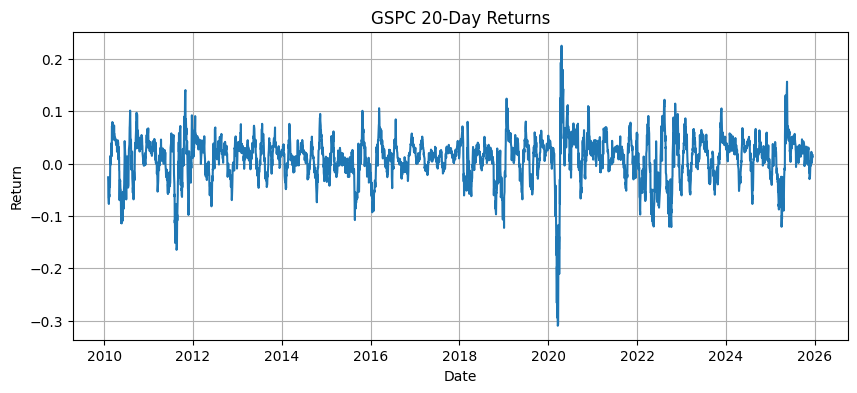

In [15]:
# Plot 20-day returns over time
import matplotlib.pyplot as plt

if '^GSPC_RET_20D' in features['feature'].values:
    ret_20d = features[features['feature'] == '^GSPC_RET_20D']['value']
    plt.figure(figsize=(10, 4))
    plt.plot(ret_20d.index, ret_20d.values)  # type: ignore
    plt.title('GSPC 20-Day Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.show()

## 4. Compute Full Feature Set

### 4.1 Run Feature Computation Pipeline

In [16]:
# Compute ALL features for ALL tickers and store in database
# This includes:
#   - Basic features (returns, momentum, volatility)
#   - Spread features (yield curves, credit spreads)
#   - Ratio features (cross-asset relationships)
#   - Global aggregates (market-wide indicators)
#
# Parameters:
#   - version: Feature set version identifier
#   - ticker_filter: None = all tickers from universe
#   - forward_fill: Fills missing data based on natural frequency
#   - business_days_only: Aligns all features to business day calendar

result = compute_all_features(
    conn,
    version='V1_ML',
    start_date='2010-01-01',
    ticker_filter=None,  # None = all tickers
    forward_fill=True,
    business_days_only=True
)

print("\nFeature computation summary:")
print(result)

Starting feature computation (version: V1_ML)...
Loading raw data...
Loaded 54 tickers
Cleaning and preparing data...
Computing basic features...
  Computed 1358533 basic features
Computing spread features...
  Computed 52373 spread features
Computing ratio features...
  Computed 46611 ratio features
Computing global aggregates...
  Computed 38451 aggregate features
Combining all features...
Total features computed: 1,495,968
Unique features: 376
Date range: 2010-01-01 to 2025-12-16
Smart forward-filling features based on natural frequency...
  Before: 1,495,968 rows
  Business days in range: 4163 days
  Processed 50/376 features
  Processed 100/376 features
  Processed 150/376 features
  Processed 200/376 features
  Processed 250/376 features
  Processed 300/376 features
  Processed 350/376 features
  Processed 376/376 features

  Frequency distribution:
    DAILY: 360 features
    WEEKLY: 8 features
    MONTHLY: 7 features
    QUARTERLY: 1 features

  After: 1,534,807 rows
  Added 38

## 5. Inspect Computed Features

### 5.1 Load Feature Dataset

In [17]:
# Load the computed feature set from database
df_features = get_features(conn, version='V1_ML', start_date='2010-01-01')
print(f"Loaded {len(df_features)} feature rows")
print(f"Unique features: {df_features['feature'].nunique()}")
print(f"\nFeature types:")
df_features['feature'].value_counts().sort_values(ascending=True)

Loaded 1534807 feature rows
Unique features: 376

Feature types:


feature
SOFR_CHG_60D       1951
SOFR_CHG_20D       1991
SOFR_CHG_1D        2010
SOFR_LEVEL         2011
BTC-USD_MOM_60D    2892
                   ... 
GBPUSD=X_LEVEL     4163
FEDFUNDS_LEVEL     4163
FX_AUD_JPY         4163
NFCI_LEVEL         4163
AUDUSD=X_LEVEL     4163
Name: count, Length: 376, dtype: int64

### 5.2 Plot Specific Feature Over Time

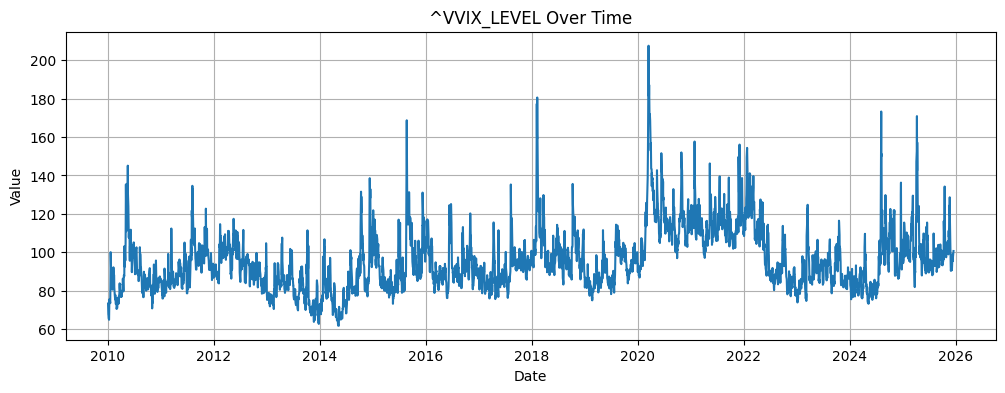


Statistics for ^VVIX_LEVEL:
count    4162.000000
mean       95.592931
std        16.007716
min        61.759998
25%        84.482502
50%        92.494999
75%       104.010002
max       207.589996
Name: value, dtype: float64


In [18]:
# Example: Visualize VVIX (VIX of VIX) over time
feature_name = '^VVIX_LEVEL'  # Change to any feature name
df_feature = df_features[df_features['feature'] == feature_name].sort_values('dt')  # type: ignore

if not df_feature.empty:
    plt.figure(figsize=(12, 4))
    plt.plot(pd.to_datetime(df_feature['dt']), df_feature['value'])
    plt.title(f'{feature_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
    
    print(f"\nStatistics for {feature_name}:")
    print(df_feature['value'].describe())
else:
    print(f"Feature {feature_name} not found")

### 5.3 View Global Aggregate Features

In [19]:
# Global features are market-wide indicators (not ticker-specific)
# Examples: risk appetite, financial conditions, global momentum
global_features = df_features[df_features['ticker'] == 'GLOBAL']
print(f"Global features: {global_features['feature'].unique()}") # type: ignore
print(f"\nSample global features:")
global_features.head(10)

Global features: ['FX_AUD_JPY' 'GLOBAL_FINANCIAL_CONDITIONS' 'COMMODITY_GOLD_OIL'
 'CREDIT_HY_SPREAD' 'CREDIT_IG_SPREAD' 'EQUITY_EM_VS_US'
 'GLOBAL_INFLATION_EXPECTATIONS' 'GLOBAL_YIELD_CURVE_SLOPE'
 'REAL_RATE_10Y' 'STYLE_CYCLICAL_VS_DEFENSIVE' 'STYLE_GROWTH_VS_VALUE'
 'STYLE_SMALL_VS_LARGE' 'VOL_VIX_LEVEL' 'VOL_VVIX_VIX' 'YCURVE_2S10S'
 'YCURVE_2S5S' 'YCURVE_5S30S' 'GLOBAL_INFLATION_REALIZED'
 'GLOBAL_GROWTH_SIGNAL' 'CREDIT_HY_CHG_20D' 'CREDIT_IG_CHG_20D'
 'GLOBAL_EQUITY_MOMENTUM' 'GLOBAL_RISK_APPETITE']

Sample global features:


,dt,ticker,asset_class,feature,value,version
6,2010-01-01,GLOBAL,MACRO,FX_AUD_JPY,0.009669,V1_ML
7,2010-01-01,GLOBAL,MACRO,GLOBAL_FINANCIAL_CONDITIONS,-0.178560,V1_ML
39,2010-01-04,GLOBAL,MACRO,COMMODITY_GOLD_OIL,13.712427,V1_ML
40,2010-01-04,GLOBAL,MACRO,CREDIT_HY_SPREAD,6.340000,V1_ML
41,2010-01-04,GLOBAL,MACRO,CREDIT_IG_SPREAD,1.880000,V1_ML
42,2010-01-04,GLOBAL,MACRO,EQUITY_EM_VS_US,0.027172,V1_ML
43,2010-01-04,GLOBAL,MACRO,FX_AUD_JPY,0.009865,V1_ML
44,2010-01-04,GLOBAL,MACRO,GLOBAL_FINANCIAL_CONDITIONS,-0.178560,V1_ML
45,2010-01-04,GLOBAL,MACRO,GLOBAL_INFLATION_EXPECTATIONS,2.255000,V1_ML
46,2010-01-04,GLOBAL,MACRO,GLOBAL_YIELD_CURVE_SLOPE,2.760000,V1_ML


### 5.4 Reconnect to Database (if needed)

In [20]:
# Long-running operations may cause connection timeout
# This cell checks and reconnects if necessary
try:
    # Test if connection is still alive
    cursor = conn.cursor()
    cursor.execute("SELECT 1")
    cursor.close()
    print("✅ Database connection is active")
except:
    print("⚠️  Connection closed, reconnecting...")
    conn = get_connection(password=db_password)
    print("✅ Reconnected to database")

✅ Database connection is active


## 6. Data Quality Diagnostics

This section validates the computed feature dataset to ensure it's production-ready for ML.

**Validation checks:**
1. **Feature frequency:** All features should be DAILY after forward-fill
2. **Weekend data:** Should be none with business_days_only=True
3. **Completeness:** All features should be 100% complete (no missing values)
4. **Start dates:** Understand when each feature becomes available
5. **Core features:** Identify features with longest history for ML training

### 6.1 Feature Frequency Analysis

In [21]:
# Validate that all features are DAILY frequency after forward-fill
# Expected: ~261 observations per year (trading days)

df_freq = categorize_feature_frequency(conn, version='V1_ML')

# Check results
print("\n" + "="*80)
print("VALIDATION RESULTS")
print("="*80)

all_daily = (df_freq['frequency'] == 'DAILY').all()
avg_obs = df_freq['obs_per_year'].mean()

if all_daily:
    print("✅ ALL features are DAILY frequency (forward-fill working)")
else:
    print("⚠️  Some features are not daily!")
    non_daily = df_freq[df_freq['frequency'] != 'DAILY']
    print(f"\nNon-daily features: {len(non_daily)}")
    print(non_daily[['feature', 'frequency', 'obs_per_year']])

if 260 <= avg_obs <= 262:
    print(f"✅ Average {avg_obs:.1f} obs/year (expected ~261 trading days)")
else:
    print(f"⚠️  Average {avg_obs:.1f} obs/year (expected ~261)")

# Show feature summary
print(f"\n📊 Feature Summary:")
print(f"   Total features: {len(df_freq)}")
print(f"   Date range: {df_freq['first_date'].min()} to {df_freq['last_date'].max()}")
print(f"   Observations per year: {df_freq['obs_per_year'].describe()[['min', 'mean', 'max']]}")

df_freq.head(10)


/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


FEATURE FREQUENCY ANALYSIS

Total features: 376

Frequency distribution:
frequency
DAILY    376
Name: count, dtype: int64

Observations per year by frequency:
           count        mean       std    min    25%    50%    75%    max
frequency                                                                
DAILY      376.0  260.968883  0.046359  260.9  260.9  261.0  261.0  261.0

VALIDATION RESULTS
✅ ALL features are DAILY frequency (forward-fill working)
✅ Average 261.0 obs/year (expected ~261 trading days)

📊 Feature Summary:
   Total features: 376
   Date range: 2010-01-01 to 2025-12-16
   Observations per year: min     260.900000
mean    260.968883
max     261.000000
Name: obs_per_year, dtype: float64


,feature,ticker,asset_class,frequency,median_gap_days,observations,obs_per_year,expected_behavior,first_date,last_date
0,000001.SS_LEVEL,000001.SS,EQUITY,DAILY,1,4162,261.0,Should be nearly complete,2010-01-04,2025-12-16
1,000001.SS_MOM_20D,000001.SS,EQUITY,DAILY,1,4142,261.0,Should be nearly complete,2010-02-01,2025-12-16
2,000001.SS_MOM_60D,000001.SS,EQUITY,DAILY,1,4096,261.0,Should be nearly complete,2010-04-06,2025-12-16
3,000001.SS_RET_1D,000001.SS,EQUITY,DAILY,1,4161,261.0,Should be nearly complete,2010-01-05,2025-12-16
4,000001.SS_RET_20D,000001.SS,EQUITY,DAILY,1,4142,261.0,Should be nearly complete,2010-02-01,2025-12-16
5,000001.SS_RET_5D,000001.SS,EQUITY,DAILY,1,4157,261.0,Should be nearly complete,2010-01-11,2025-12-16
6,000001.SS_RET_60D,000001.SS,EQUITY,DAILY,1,4096,261.0,Should be nearly complete,2010-04-06,2025-12-16
7,000001.SS_VOL_20D,000001.SS,EQUITY,DAILY,1,4152,261.0,Should be nearly complete,2010-01-18,2025-12-16
8,000001.SS_VOL_60D,000001.SS,EQUITY,DAILY,1,4127,261.0,Should be nearly complete,2010-02-22,2025-12-16
9,AUDUSD=X_LEVEL,AUDUSD=X,FX,DAILY,1,4163,260.9,Should be nearly complete,2010-01-01,2025-12-16


### 6.2 Weekend/Holiday Data Check

In [23]:
# Verify that no weekend data exists (should be business days only)
# All dates should be Monday-Friday

date_analysis = check_forward_fill_behavior(conn, version='V1_ML')

# Validate results
has_weekends = date_analysis['is_weekend'].sum() > 0

if not has_weekends:
    print("\n✅ VALIDATION PASSED: No weekend data found")
else:
    print("\n❌ VALIDATION FAILED: Weekend data detected")
    print("   This indicates forward-fill did not use business_days_only")
    
# Check day distribution is balanced (roughly equal Mon-Fri)
day_counts = date_analysis.groupby('day_of_week').size()
if len(day_counts) == 5:  # Only weekdays
    variance = day_counts.std()
    if variance < 5:  # Low variance = balanced
        print("✅ Day-of-week distribution is balanced")
    else:
        print(f"⚠️  Day-of-week variance is {variance:.1f} (check for missing days)")

date_analysis.tail()


/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:122: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


FORWARD-FILL BEHAVIOR CHECK

Total dates in database: 4,163
Weekend dates: 0

Day of week distribution:
  Monday: 833
  Tuesday: 833
  Wednesday: 832
  Thursday: 832
  Friday: 833
  Saturday: 0
  Sunday: 0

✅ No weekend data found - forward-fill is working correctly!

✅ VALIDATION PASSED: No weekend data found
✅ Day-of-week distribution is balanced


,dt,num_features,day_of_week,is_weekend
4158,2025-12-10,376,2,False
4159,2025-12-11,376,3,False
4160,2025-12-12,376,4,False
4161,2025-12-15,376,0,False
4162,2025-12-16,376,1,False


### 6.3 Feature Completeness Analysis

In [24]:
# Check for missing data across all features
# Expected: 100% complete for all features after forward-fill

df_completeness = analyze_feature_completeness(conn, version='V1_ML')

# Validate results
print("\n" + "="*80)
print("COMPLETENESS VALIDATION")
print("="*80)

all_complete = (df_completeness['pct_complete'] == 100.0).all()
avg_complete = df_completeness['pct_complete'].mean()
incomplete_count = (df_completeness['pct_complete'] < 100).sum()

if all_complete:
    print("✅ ALL features are 100% complete!")
    print(f"   Total features: {len(df_completeness)}")
    print(f"   Total rows: {df_completeness['actual_rows'].sum():,}")
    print(f"   No missing data detected")
else:
    print(f"⚠️  {incomplete_count} features are not complete")
    print(f"   Average completeness: {avg_complete:.1f}%")
    incomplete = df_completeness[df_completeness['pct_complete'] < 100]
    print(f"\n   Incomplete features:")
    print(incomplete[['feature', 'pct_complete', 'missing_days']].head(10)) #type: ignore

df_completeness.head(10)


/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:230: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


Loaded 1,534,807 feature rows
Date range: 2010-01-01 to 2025-12-16
Unique features: 376

FEATURE COMPLETENESS ANALYSIS

Total features: 376

Start date distribution:
first_date
2010-01-04    57
2010-02-02    40
2010-03-31    38
2010-01-05    38
2010-02-01    29
2010-01-11    23
2010-01-19    20
2010-02-17    20
2010-03-29    18
2010-01-01    15
Name: count, dtype: int64

Completeness summary:
count    376.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: pct_complete, dtype: float64

FEATURES WITH MISSING DATA (< 95% complete)
✅ No features with significant missing data!

FEATURES WITH LARGE GAPS (> 7 days)
✅ No features with large gaps!

COMPLETENESS VALIDATION
✅ ALL features are 100% complete!
   Total features: 376
   Total rows: 1,534,807
   No missing data detected


,feature,ticker,asset_class,first_date,last_date,actual_rows,expected_bdays,pct_complete,missing_days,max_gap_days,large_gaps
0,000001.SS_LEVEL,000001.SS,EQUITY,2010-01-04,2025-12-16,4162,4162,100.0,0,3,0
1,000001.SS_MOM_20D,000001.SS,EQUITY,2010-02-01,2025-12-16,4142,4142,100.0,0,3,0
2,000001.SS_MOM_60D,000001.SS,EQUITY,2010-04-06,2025-12-16,4096,4096,100.0,0,3,0
3,000001.SS_RET_1D,000001.SS,EQUITY,2010-01-05,2025-12-16,4161,4161,100.0,0,3,0
4,000001.SS_RET_20D,000001.SS,EQUITY,2010-02-01,2025-12-16,4142,4142,100.0,0,3,0
5,000001.SS_RET_5D,000001.SS,EQUITY,2010-01-11,2025-12-16,4157,4157,100.0,0,3,0
6,000001.SS_RET_60D,000001.SS,EQUITY,2010-04-06,2025-12-16,4096,4096,100.0,0,3,0
7,000001.SS_VOL_20D,000001.SS,EQUITY,2010-01-18,2025-12-16,4152,4152,100.0,0,3,0
8,000001.SS_VOL_60D,000001.SS,EQUITY,2010-02-22,2025-12-16,4127,4127,100.0,0,3,0
9,AUDUSD=X_LEVEL,AUDUSD=X,FX,2010-01-01,2025-12-16,4163,4163,100.0,0,3,0


### 6.4 Feature Start Date Analysis

In [27]:
# Analyze when each feature first becomes available
# Important for determining ML training window

df_starts = get_feature_start_dates(conn, version='V1_ML')

# Analyze start date distribution
print("\n" + "="*80)
print("START DATE INSIGHTS")
print("="*80)
 
earliest = df_starts['first_date'].min()
latest = df_starts['first_date'].max()
date_spread = (latest - earliest).days

print(f"Earliest feature start: {earliest.date()}")
print(f"Latest feature start: {latest.date()}")
print(f"Date spread: {date_spread} days ({date_spread/365.25:.1f} years)")

# Show start date clusters
print(f"\nTop 10 start dates (# of features):")
print(df_starts['first_date'].value_counts().head(10))

# Features availability over time
cutoff_dates = ['2010-01-05', '2011-01-01', '2014-01-01', '2018-01-01']
print(f"\nFeature availability timeline:")
for cutoff in cutoff_dates:
    count = (df_starts['first_date'] <= cutoff).sum()
    print(f"  By {cutoff}: {count:3d} features ({count/len(df_starts)*100:.1f}%)")

df_starts.sort_values('first_date', ascending=False).head(15)


FEATURE START DATES

Total features: 376

Earliest start: 2010-01-01
Latest start: 2018-06-26

Features starting by common dates:
  By 2010-01-04: 72 features
  By 2011-01-03: 361 features
  By 2014-01-02: 363 features
  By 2018-01-02: 372 features

Start date distribution:
first_date
2010-01-04    57
2010-02-02    40
2010-01-05    38
2010-03-31    38
2010-02-01    29
2010-01-11    23
2010-02-17    20
2010-01-19    20
2010-03-29    18
2010-01-01    15
2010-01-29     8
2011-01-03     8
2010-03-26     8
2010-01-08     5
2010-01-25     4
Name: count, dtype: int64

START DATE INSIGHTS
Earliest feature start: 2010-01-01
Latest feature start: 2018-06-26
Date spread: 3098 days (8.5 years)

Top 10 start dates (# of features):
first_date
2010-01-04    57
2010-02-02    40
2010-01-05    38
2010-03-31    38
2010-02-01    29
2010-01-11    23
2010-02-17    20
2010-01-19    20
2010-03-29    18
2010-01-01    15
Name: count, dtype: int64

Feature availability timeline:
  By 2010-01-05: 110 features (29

/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:336: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


,feature,ticker,first_date,total_observations
375,SOFR_CHG_60D,SOFR,2018-06-26,1951
374,SOFR_CHG_20D,SOFR,2018-05-01,1991
373,SOFR_CHG_1D,SOFR,2018-04-04,2010
372,SOFR_LEVEL,SOFR,2018-04-03,2011
371,BTC-USD_RET_60D,BTC-USD,2014-11-17,2892
370,BTC-USD_MOM_60D,BTC-USD,2014-11-17,2892
369,BTC-USD_VOL_60D,BTC-USD,2014-10-17,2913
368,BTC-USD_RET_20D,BTC-USD,2014-10-07,2921
367,BTC-USD_MOM_20D,BTC-USD,2014-10-07,2921
366,BTC-USD_VOL_20D,BTC-USD,2014-09-29,2927


### 6.5 Final Validation Summary

In [28]:
# Comprehensive validation report with pass/fail status
# This cell aggregates all validation checks

print("=" * 80)
print("V2_FWD_FILL DATASET VALIDATION SUMMARY")
print("=" * 80)

# Collect all validation results
validations = {
    'All features are DAILY frequency': (df_freq['frequency'] == 'DAILY').all(),
    'No weekend data present': date_analysis['is_weekend'].sum() == 0,
    'All features 100% complete': (df_completeness['pct_complete'] == 100.0).all(),
}

print("\n📋 Validation Checklist:")
all_passed = True
for check, result in validations.items():
    status = "✅ PASS" if result else "❌ FAIL"
    print(f"  {status}: {check}")
    if not result:
        all_passed = False

print("\n" + "=" * 80)
print("📊 DATASET STATISTICS")
print("=" * 80)
print(f"  Version: V2_FWD_FILL")
print(f"  Total features: {len(df_freq)}")
print(f"  Total data rows: {df_completeness['actual_rows'].sum():,}")
print(f"  Date range: {df_completeness['first_date'].min()} to {df_completeness['last_date'].max()}")
print(f"  Trading days: ~{int(df_freq['obs_per_year'].mean())} per year")

print("\n" + "=" * 80)
if all_passed:
    print("🎉 ALL VALIDATIONS PASSED!")
    print("   Dataset is production-ready for machine learning")
    print("   - Complete: No missing values")
    print("   - Aligned: All features on same business day calendar")
    print("   - Clean: Forward-filled appropriately")
else:
    print("⚠️  SOME VALIDATIONS FAILED")
    print("   Review failed checks above and rerun feature computation if needed")

print("=" * 80)


V2_FWD_FILL DATASET VALIDATION SUMMARY

📋 Validation Checklist:
  ✅ PASS: All features are DAILY frequency
  ✅ PASS: No weekend data present
  ✅ PASS: All features 100% complete

📊 DATASET STATISTICS
  Version: V2_FWD_FILL
  Total features: 376
  Total data rows: 1,534,807
  Date range: 2010-01-01 to 2025-12-16
  Trading days: ~260 per year

🎉 ALL VALIDATIONS PASSED!
   Dataset is production-ready for machine learning
   - Complete: No missing values
   - Aligned: All features on same business day calendar
   - Clean: Forward-filled appropriately


## 7. Cleanup

In [ ]:
# Close database connection
conn.close()
print("Database connection closed")